# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_auc_score
%matplotlib inline

# Loading and checking data

In [2]:
data = pd.read_csv("diabetic_data.csv", na_values ="?", dtype={'payer_code': 'object'})
data.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


- There is another part of this dataset given by a second table, which tells us about the type of admissions. 
- Missing values are recorded in three ways: Null, Not available or Not Mapped. I will encode all of them as unknown. 

In [3]:
admissions = pd.read_csv('admissions_mapping.csv')
admissions

,admission_type_id,admission_type_description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [4]:
admissions['admission_type_description'] = ['unknown' if ((x in ['Not Available', 'Not Mapped', 'NULL']) | (pd.isnull(x))) else x 
                                                 for x in admissions['admission_type_description']]

# Joining Data

In [5]:
df = pd.merge(data, admissions, how = 'left',left_on='admission_type_id', right_on='admission_type_id')

In [6]:
df.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,unknown
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,Emergency


In [7]:
# checking Null in data 
#df.isnull().any()

In [8]:
#checking the datatype for each columns
#df.dtype()

# Cleaning data

In [9]:
# using the select_types to select the numerical and object type col in dataframe

num_col = df.select_dtypes(include = [np.number]).columns
obj_col = df.select_dtypes(include = ['object']).columns


In [10]:
# We can replace Null in object columns with "unknown", in numerical colomns with Zero
df[obj_col] = df[obj_col].fillna("unknown")
df[num_col] = df[num_col].fillna(0)

In [11]:
df.head(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_description
0,2278392,8222157,Caucasian,Female,[0-10),unknown,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,unknown
1,149190,55629189,Caucasian,Female,[10-20),unknown,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Emergency


# Encode the data 

 - Three coloumns diag_1, diag_2, diag_3 show diagnostic codes, which are integers varying from 0 to 999. 
 - Break them down to number of levels. That will be easier to handle. 

In [12]:
def create_map():
    ## List of tuples with name and number of repititons.
    name_list = [('infections', 139),
                ('neoplasms', (239 - 139)),
                ('endocrine', (279 - 239)),
                ('blood', (289 - 279)),
                ('mental', (319 - 289)),
                ('nervous', (359 - 319)),
                ('sense', (389 - 359)),
                ('circulatory', (459-389)),
                ('respiratory', (519-459)),
                ('digestive', (579 - 519)),
                ('genitourinary', (629 - 579)),
                ('pregnancy', (679 - 629)),
                ('skin', (709 - 679)),
                ('musculoskeletal', (739 - 709)),
                ('congenital', (759 - 739)),
                ('perinatal', (779 - 759)),
                ('ill-defined', (799 - 779)),
                ('injury', (999 - 799))]
    ## Loop over the tuples to create a dictionary to map codes 
    ## to the names.
    out_dict = {}
    count = 1
    for name, num in name_list:
        for i in range(num):
            out_dict.update({str(count): name})  
            count += 1
    return out_dict
  

def map_codes(df, codes):
    import pandas as pd
    col_names = df.columns.tolist()
    for col in col_names:
        temp = [] 
        for num in df[col]:           
            if ((num is None) | (num in ['unknown', '?']) | (pd.isnull(num))): temp.append('unknown')
            elif(num.upper()[0] == 'V'): temp.append('supplemental')
            elif(num.upper()[0] == 'E'): temp.append('injury')
            else: 
                lkup = num.split('.')[0]
                temp.append(codes[lkup])           
        df.loc[:, col] = temp               
    return df 


col_list = ['diag_1', 'diag_2', 'diag_3']
codes = create_map()
df[col_list] = map_codes(df[col_list], codes)

/Users/Dien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


- Lable column is "readmitted", with three values NO, >30 and <30
- Map this column to two values: No or Yes (>30 and <30)

In [13]:
def set_readmit_class(x):
    return ['NO' if (y == 'NO') else 'YES' for y in x]

df['readmitted'] = set_readmit_class(df['readmitted'])

In [14]:
# Drop some cols which are not useful for modeling 
df = df.drop(['encounter_id', "patient_nbr", 'admission_type_id'], axis =1) 
print("Shape of Data set: ", df.shape)

Shape of Data set:  (101766, 48)


In [15]:
# quick statistic check on numerical columns
df.describe()

,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


# Normalize Data using the standard normalization

In [16]:
# List of numerical columns which need to be normalized
norm_list = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

In [17]:
# Create the standardscaler model to normalize data
norm = StandardScaler()

df[norm_list] = norm.fit_transform(df[norm_list])

In [18]:
df.describe()

,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05
mean,3.715642,5.754437,2.357310e-14,3.243938e-16,4.233273e-15,-2.183720e-14,1.000822e-13,2.509265e-14,-4.314501e-14,1.284175e-13
std,5.280166,4.064081,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,1.000000,1.000000,-1.137649e+00,-2.139630e+00,-7.853977e-01,-1.848268e+00,-2.914615e-01,-2.126202e-01,-5.032762e-01,-3.321596e+00
25%,1.000000,1.000000,-8.026506e-01,-6.147950e-01,-7.853977e-01,-7.409197e-01,-2.914615e-01,-2.126202e-01,-5.032762e-01,-7.357332e-01
50%,1.000000,7.000000,-1.326548e-01,4.596660e-02,-1.991621e-01,-1.257264e-01,-2.914615e-01,-2.126202e-01,-5.032762e-01,2.986119e-01
75%,4.000000,7.000000,5.373411e-01,7.067282e-01,3.870736e-01,4.894670e-01,-2.914615e-01,-2.126202e-01,2.885790e-01,8.157845e-01
max,28.000000,25.000000,3.217324e+00,4.518815e+00,2.732016e+00,7.994826e+00,3.285094e+01,8.146673e+01,1.612568e+01,4.435992e+00


# Visualization Data

In [19]:
import seaborn as sns
sns.set_style('ticks')

In [20]:
# Select the numerical and object columns after dropping a few columns above
num = df.select_dtypes(include = [np.number]).columns
obj = df.select_dtypes(include = ['object']).columns

In [21]:
print("Number of num col and obj col: ",len(num), len(obj))

Number of num col and obj col:  10 38


- We have 10 numerical and 38 categorical colums. Uncomment the following codes to visualize the data
  - For numerical colums: Using the box plots and histogram
  - For categorical columns: Using Bar plots

I will plot the distribution of each feature for the two values (YES or NO) of the "readmitted" column. This data set is tough, the pattern is subtle, and only a few feautes show different distributions bewteen the two categories. I will select a few columns to make the plots.


# Visualize for every features in data set

In [22]:
# The box plots for ALL numerical columns

#fig,axes = plt.subplots(5,2, figsize = (16,24))
#for i, t in enumerate(num):
    #sns.boxplot(y =t, x = "readmitted", data= df, ax = axes[i%5, i%2])   

In [23]:
# The histogram plots for ALL numerical columns

#fig,axes = plt.subplots(5,2, figsize = (16,24))
#for i, t in enumerate(num):
    #sns.countplot(x =t, hue= "readmitted", data= df, ax = axes[i%5, i%2])

# Visualize for selected features

In [24]:
# Selected numerical columns for box plots
num_sel = ['time_in_hospital', 'number_inpatient', "number_diagnoses" ]

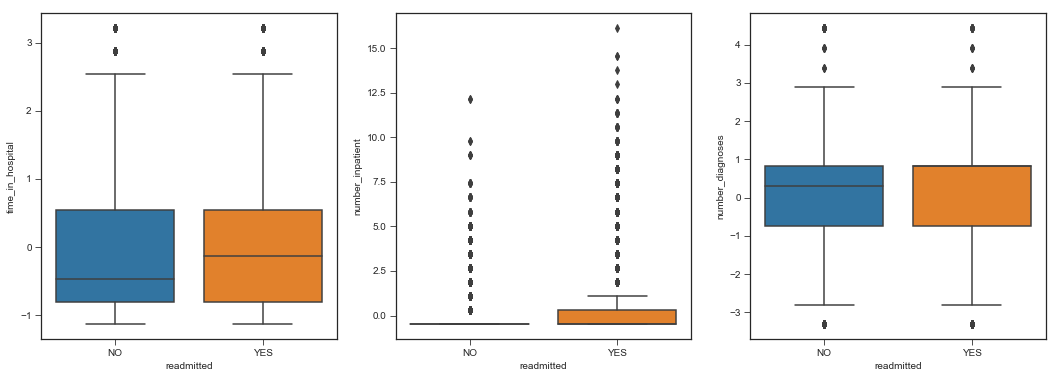

In [25]:
# The Box plots for selected numerical columns
fig,axes = plt.subplots(1,3, figsize = (18,6))
for i, t in enumerate(num_sel):
    sns.boxplot(y =t, x = "readmitted", data= df, ax = axes[i])

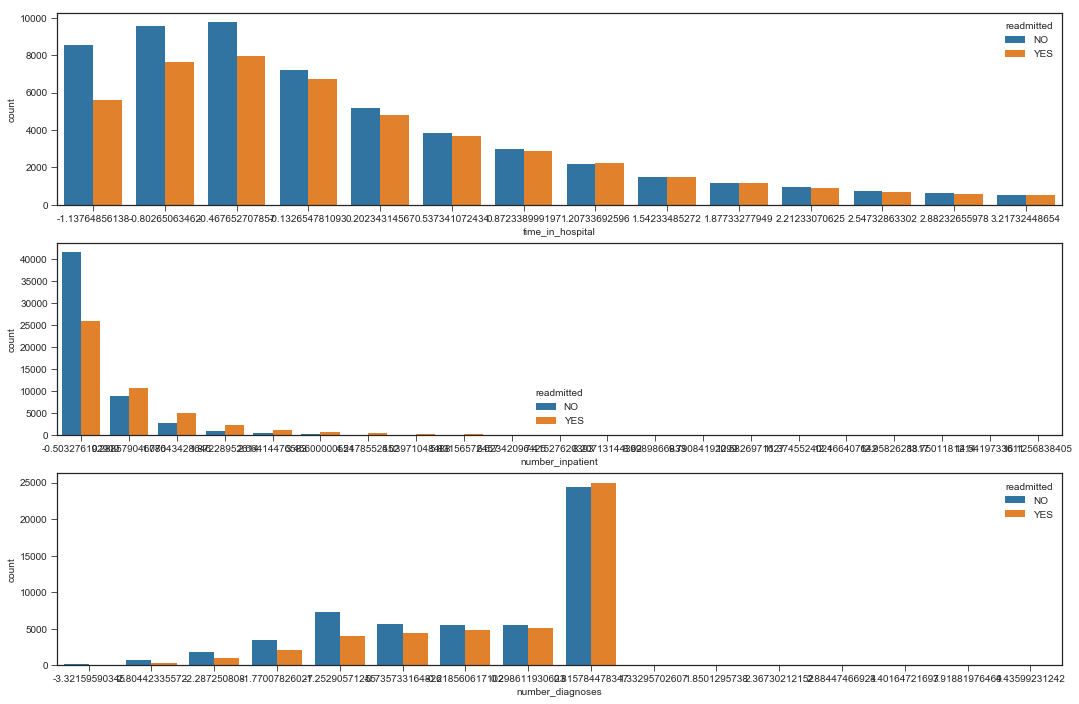

In [26]:
# The histogram plots for selected numerical columns

fig,axes = plt.subplots(3,1, figsize =(18,12))
for i, t in enumerate(num_sel):
    sns.countplot(x =t, hue= "readmitted", data= df, ax = axes[i])

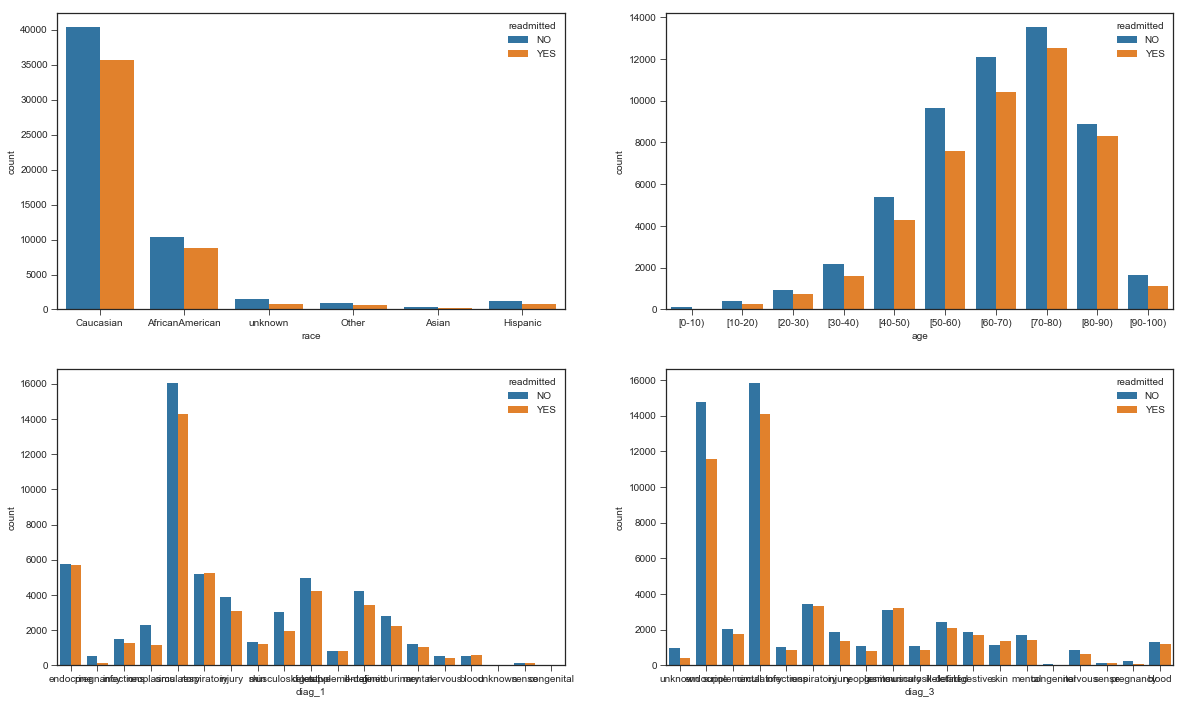

In [27]:
# Selected Categorical Columns for Bar plots

obj_sel = ["race", 'age', 'diag_1',"diag_3"]

# the Bar plots 

fig,axes = plt.subplots(2,2, figsize =(20,12))

for i, t in enumerate(obj_sel):
    sns.countplot(t, data=df, hue='readmitted', ax = axes[i//2, i%2]);
     

# Encode data to convert Category to numeric

In [28]:
# I will save the lable columns in the Y and data in X
Y = df['readmitted']
X = df.drop(['readmitted'], axis =1)
X = pd.get_dummies(X)

# Splitting data to Train and Test sets, ready for modeling

In [29]:
# 60% of data will be used to train model and 40% of data will be used to test model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

In [30]:
# checking the size of train and test data
print("Shape of Train and Test Sets: ", X_train.shape, X_test.shape)

Shape of Train and Test Sets:  (61059, 276) (40707, 276)


In [31]:
# Checking the balance of data  in Train and Test set
print("NO: Not readmitted , YES: readmitted")
print("For train data: ")
print(pd.value_counts(Y_train, normalize = True))
print("For test data:  ")
print(pd.value_counts(Y_test, normalize = True))

NO: Not readmitted , YES: readmitted
For train data: 
NO     0.541296
YES    0.458704
Name: readmitted, dtype: float64
For test data:  
NO     0.535854
YES    0.464146
Name: readmitted, dtype: float64


# Training data using the Logistics regression built in Sklearn

In [32]:
# create model logistic as logistic regression using Sklearn 

logistic = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005)
logistic.fit(X_train, Y_train)
Y_log = logistic.predict(X_test)

In [33]:
# Checking the accuracy of the model 
print(" The accuracy of the Logistic regression model:" ,logistic.score(X_test, Y_test))

 The accuracy of the Logistic regression model: 0.620458397819


In [34]:
# checking the confusion matrix
print(confusion_matrix(Y_test, Y_log))

[[17842  3971]
 [11479  7415]]


In [35]:
# Checking the summary of classification
print(classification_report(Y_test, Y_log, target_names = ['NO', 'YES']))

             precision    recall  f1-score   support

         NO       0.61      0.82      0.70     21813
        YES       0.65      0.39      0.49     18894

avg / total       0.63      0.62      0.60     40707



In [36]:
# Checking the performance of model using ROC curve plots
y_score = logistic.decision_function(X_test)

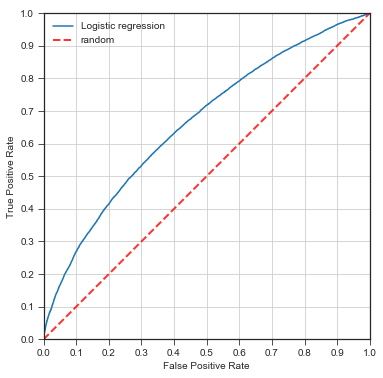

In [37]:
fpr_log, tpr_log, thresholds = roc_curve(Y_test, y_score, pos_label='YES')
plt.figure(figsize=(6,6))
plt.plot(fpr_log, tpr_log, label ="Logistic regression")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.axes().set_aspect('equal')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Training data using AdaBoosted Classification model

In [38]:
# create ABC as adaboosted classifier model on the training data and training label
ada_clf = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 123)
ada_clf.fit(X_train, Y_train)
Y_abc = ada_clf.predict(X_test)

In [39]:
# Checking the accuracy of model 
print("The accurary of AdaBoosted Classification model: ", ada_clf.score(X_test, Y_test))

The accurary of AdaBoosted Classification model:  0.617903554671


In [40]:
# Checking the confusion Matrix
print(confusion_matrix(Y_test, Y_abc))

[[17259  4554]
 [11000  7894]]


In [41]:
#Checking the summary of classification
print(classification_report(Y_test, Y_abc, target_names = ['NO', 'YES']))

             precision    recall  f1-score   support

         NO       0.61      0.79      0.69     21813
        YES       0.63      0.42      0.50     18894

avg / total       0.62      0.62      0.60     40707



In [42]:
# calculate the False Positive and True Positive rate to get the ROC curve  
y_score = ada_clf.decision_function(X_test)
fpr_abc, tpr_abc, thresholds = roc_curve(Y_test, y_score, pos_label='YES')

# Training data using Random Forest Classifier

In [43]:
rf_clf = RandomForestClassifier(random_state=42,n_estimators=500)
rf_clf.fit(X_train, Y_train)
Y_rf = rf_clf.predict(X_test)

In [44]:
y_score =rf_clf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(Y_test, y_score, pos_label='YES')

In [45]:
#checking the accuracy of the model
print(" Accuracy of Randomeforest classification: ", rf_clf.score(X_test, Y_test))

 Accuracy of Randomeforest classification:  0.641658682782


In [46]:
print(confusion_matrix(Y_test, Y_rf))

[[16232  5581]
 [ 9006  9888]]


In [47]:
print(classification_report(Y_test, Y_rf, target_names = ['NO', 'YES']))

             precision    recall  f1-score   support

         NO       0.64      0.74      0.69     21813
        YES       0.64      0.52      0.58     18894

avg / total       0.64      0.64      0.64     40707



# Hyperparameters Tunning for AdaBoosted 

In [48]:
# Do parameter tunning for Adaboosted 

from sklearn.model_selection import GridSearchCV

ada = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 123)
param_grid ={
        'n_estimators': [100, 200,500],
        'learning_rate': [0.2,0.5,1.0],
},
grid_ada = GridSearchCV(ada, cv=3, n_jobs=3, param_grid=param_grid)
grid_ada.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=20, random_state=123),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=({'n_estimators': [100, 200, 500], 'learning_rate': [0.2, 0.5, 1.0]},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
#The accuracy of the model with the best parameters
grid_ada.score(X_test, Y_test)

0.63957058982484583

In [50]:
# checking the best parameters
grid_ada.best_params_

{'learning_rate': 0.5, 'n_estimators': 500}

In [55]:
Y_grid_ada = grid_ada.predict(X_test)

In [56]:
print(classification_report(Y_test, Y_grid_ada, target_names = ['NO', 'YES']))

             precision    recall  f1-score   support

         NO       0.64      0.77      0.70     21813
        YES       0.65      0.49      0.56     18894

avg / total       0.64      0.64      0.63     40707



In [51]:
# Checking the confustion matrix and the tunned ADA
y_grid_ada_score = grid_ada.decision_function(X_test)
fpr_grid_ada, tpr_grid_ada, thresholds_grid_ada = roc_curve(Y_test, y_grid_ada_score, pos_label='YES')

# Comparison the performance of different Models

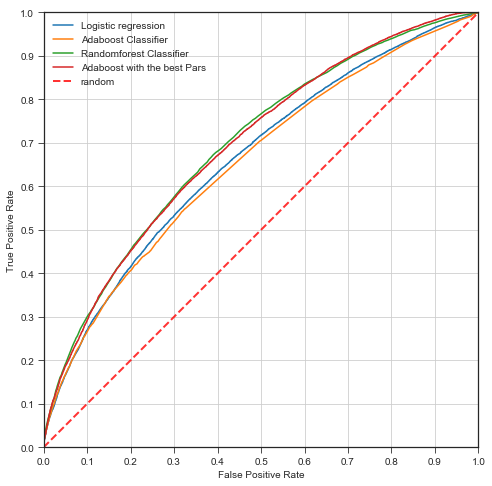

In [52]:
#compare the ROC curve between different models
plt.figure(figsize=(8,8))
plt.plot(fpr_log, tpr_log, label='Logistic regression')
plt.plot(fpr_abc, tpr_abc, label='Adaboost Classifier')
plt.plot(fpr_rf, tpr_rf, label='Randomforest Classifier')
plt.plot(fpr_grid_ada, tpr_grid_ada, label='Adaboost with the best Pars')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
plt.axes().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Summary
From visualization we mentioned that this set of data is very tough, the pattern is subtle. It is challenging for modeling this data set. 
- All of model I used including Logistic Regression, Adaboosted classifier, Random Forest classifier, they pperform very similarly in term of accuracy, only reach the level of 61% to 64%. This is not good YET and need more work to improve the performance.
- The model gave the best performance is Random Forest classifier. I also see that the hyper parameters tuning on Adaboost classifier helped to improve the model but not much (accuarcy increse from 62% to 64%)
- I looked at confustion-matrix, precision, recall and F1-score for each model for more evaluation as well. I see that the accuracy is very similar among the model but the recall for readmission is quiet different. The lowest Recall for readmission is 39% using Logistics Regression and the highest is 52% using the Random Forest classifier. Eventhough they are very low but we can see that the Random Forest classifier not only have the best performance on accuracy it also have the better prediction on readmission samples.